In [1]:
import math
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os

In [34]:
# Set random seed
torch.manual_seed(42)

# Load data
df = pd.read_csv('./DataProcess/station/1037A/1037A_2020.csv')
folderPath = './DataProcess/station/1037A'
df.dropna()
df.head()
features = ['PM10', 'SO2', 'NO2', 'O3', 'CO']
target = 'PM2.5'
print(df.head())
print(df['date'])

       date  hour   AQI  PM2.5   PM10   SO2   NO2   O3   CO
0  20200101     0  74.0   54.0   77.0  24.0  57.0  9.0  1.5
1  20200101     1  70.0   51.0   84.0  21.0  56.0  8.0  1.3
2  20200101     2  75.0   55.0   97.0  24.0  58.0  8.0  1.5
3  20200101     3  82.0   60.0  107.0  29.0  62.0  9.0  1.6
4  20200101     4  80.0   59.0  109.0  26.0  60.0  9.0  1.5
0       20200101
1       20200101
2       20200101
3       20200101
4       20200101
          ...   
8741    20201231
8742    20201231
8743    20201231
8744    20201231
8745    20201231
Name: date, Length: 8746, dtype: int64


In [53]:
df.dropna(inplace=True)

In [54]:
df.shape

(8301, 10)

In [55]:
# 将日期和小时列合并为一个字符串列
df['datetime'] = df['date'].astype(str).str.zfill(8) + '-' + df['hour'].astype(str).str.zfill(2)
print(df['datetime'])

0       20200101-00
1       20200101-01
2       20200101-02
3       20200101-03
4       20200101-04
           ...     
8741    20201231-19
8742    20201231-20
8743    20201231-21
8744    20201231-22
8745    20201231-23
Name: datetime, Length: 8301, dtype: object


In [56]:
# 将合并后的字符串列转换为datetime类型
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y%m%d-%H')
print(df['datetime'])

0      2020-01-01 00:00:00
1      2020-01-01 01:00:00
2      2020-01-01 02:00:00
3      2020-01-01 03:00:00
4      2020-01-01 04:00:00
               ...        
8741   2020-12-31 19:00:00
8742   2020-12-31 20:00:00
8743   2020-12-31 21:00:00
8744   2020-12-31 22:00:00
8745   2020-12-31 23:00:00
Name: datetime, Length: 8301, dtype: datetime64[ns]


In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [58]:
# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(df[features])
scaled_target = scaler.fit_transform(df[[target]].values)

In [59]:
print(scaled_features)
print(scaled_target)

[[0.15550756 0.14193548 0.34355828 0.02564103 0.09333333]
 [0.17062635 0.12258065 0.33742331 0.0224359  0.08      ]
 [0.1987041  0.14193548 0.34969325 0.0224359  0.09333333]
 ...
 [0.16198704 0.09032258 0.41104294 0.02564103 0.07333333]
 [0.1663067  0.08387097 0.41104294 0.0224359  0.07333333]
 [0.16846652 0.09032258 0.41717791 0.01923077 0.08      ]]
[[0.13783784]
 [0.12972973]
 [0.14054054]
 ...
 [0.12702703]
 [0.12432432]
 [0.15135135]]


In [60]:
# Prepare data for Informer
X_scaled = scaled_features.reshape((scaled_features.shape[0], 1, scaled_features.shape[1]))
y_scaled = scaled_target.reshape((scaled_target.shape[0], 1))

In [61]:
print(X_scaled)
print(y_scaled)

[[[0.15550756 0.14193548 0.34355828 0.02564103 0.09333333]]

 [[0.17062635 0.12258065 0.33742331 0.0224359  0.08      ]]

 [[0.1987041  0.14193548 0.34969325 0.0224359  0.09333333]]

 ...

 [[0.16198704 0.09032258 0.41104294 0.02564103 0.07333333]]

 [[0.1663067  0.08387097 0.41104294 0.0224359  0.07333333]]

 [[0.16846652 0.09032258 0.41717791 0.01923077 0.08      ]]]
[[0.13783784]
 [0.12972973]
 [0.14054054]
 ...
 [0.12702703]
 [0.12432432]
 [0.15135135]]


In [62]:
# Split dataset
train_size = int(0.99 * len(X_scaled))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]
print(X_train.shape, X_test.shape) # (n_samples, 1, n_features)
print(y_train.shape, y_test.shape)

# Create TensorDataset
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device),
                              torch.tensor(y_train, dtype=torch.float32).to(device))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device),
                             torch.tensor(y_test, dtype=torch.float32).to(device))

(8217, 1, 5) (84, 1, 5)
(8217, 1) (84, 1)


In [129]:
# Create DataLoader
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [130]:
class Informer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads, num_layers, dropout=0.1):
        super(Informer, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.self_attention_layers = nn.ModuleList(
            [nn.MultiheadAttention(hidden_dim, num_heads) for _ in range(num_layers)]
        )
        self.decoder = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Input layer
        x = self.input_layer(x)

        # Self-attention layers

        for layer in self.self_attention_layers:
            x, _ = layer(x, x, x)  # Self-attention

        # Output layer
        x = self.decoder(x)
        return x.squeeze(-1)

In [131]:
# Model parameters
input_dim = 5  # Input feature dimension
hidden_dim = 64  # Hidden layer dimension
output_dim = 1  # Output dimension (target)
num_heads = 4  # Number of attention heads
num_layers = 2  # Number of self-attention layers

# Instantiate model
model = Informer(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim,
                 num_heads=num_heads, num_layers=num_layers).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [132]:
# Train model
for epoch in range(100):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.0024153392296284437
Epoch 2, Loss: 0.0012243114179000258
Epoch 3, Loss: 2.4004533770494163e-05
Epoch 4, Loss: 0.0005944992881268263
Epoch 5, Loss: 0.0007052068831399083
Epoch 6, Loss: 0.0004440222983248532
Epoch 7, Loss: 0.00015735134365968406
Epoch 8, Loss: 0.0008086934685707092
Epoch 9, Loss: 0.003690143348649144
Epoch 10, Loss: 0.004539574030786753
Epoch 11, Loss: 1.0333782483940013e-05
Epoch 12, Loss: 0.009848528541624546
Epoch 13, Loss: 0.00030692986911162734
Epoch 14, Loss: 4.316382546676323e-05
Epoch 15, Loss: 0.00015161375631578267
Epoch 16, Loss: 0.0008197759743779898
Epoch 17, Loss: 6.588432006537914e-05
Epoch 18, Loss: 0.0032340881880372763
Epoch 19, Loss: 0.005373391788452864
Epoch 20, Loss: 0.001822256250306964
Epoch 21, Loss: 0.000748337828554213
Epoch 22, Loss: 0.0004805188800673932
Epoch 23, Loss: 4.666359745897353e-05
Epoch 24, Loss: 2.7833917556563392e-05
Epoch 25, Loss: 0.0003448539646342397
Epoch 26, Loss: 0.0006110818358138204
Epoch 27, Loss: 0.001

In [133]:
# Model evaluation
model.eval()
with torch.no_grad():
    predictions = []
    actuals = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predictions.extend(outputs.cpu().numpy().flatten())
        actuals.extend(labels.cpu().numpy().flatten())

In [134]:
# Inverse normalization
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))
# 保存模型
torch.save(model, 'model.pth')

In [135]:
# 加载模型
model = torch.load('model.pth')
# Check shape
print(predictions.shape)
print(actuals.shape)

(84, 1)
(84, 1)


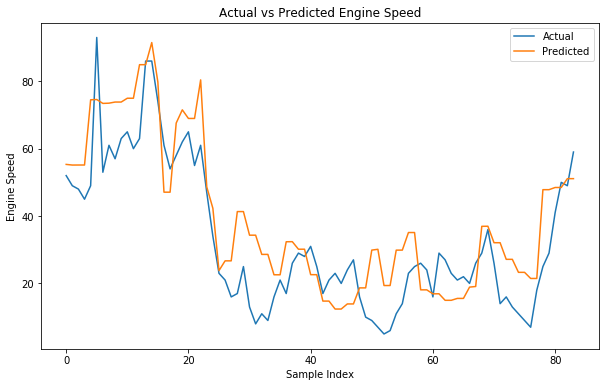

In [136]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs Predicted Engine Speed')
plt.xlabel('Sample Index')
plt.ylabel('Engine Speed')
plt.legend()
plt.show()